# Learning the basics of Keras, training a CNN classifier on the MNIST data set.

With this exercise I'm trying to learn the basics of training an ANN with Keras. I will define and train a CNN classifier on the MNIST data set.

I will try different configurations from intuition only (I won't be methodic), based on what I learned from the book "Deep Learning with Python" (available at https://livebook.manning.com/book/deep-learning-with-python-second-edition/deep-learning-with-python/).

This is a personal exercise so I won't explain everything in detail either.


# Import libraries
Import the necessary libraries to run this notebook:

In [1]:
from tensorflow.keras.datasets import mnist

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python import train

import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

# Load and prepare the MNIST data set

Load de MNIST data set form Keras:

In [2]:
(x_train, y_train), (x_test, y_test) = (mnist.load_data())

11501568/11490434 [==============================] - 0s 0us/step


Show the first image and some properties:

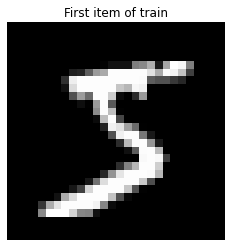

Label: 5
Shape: (28, 28)
Max/min: 255 0


In [3]:
plt.imshow(x_train[0].reshape(28,28))
plt.axis('off')
plt.set_cmap('gray')
plt.title("First item of train")
plt.show()
print("Label:", y_train[0])
print("Shape:", x_train[0].shape)
print("Max/min:", x_train[0].max(), x_train[0].min())

Add one dimmension to the train and test data to fit the expected shape of the network input:

In [4]:
x_train = x_train[:, :, :, np.newaxis]
x_test = x_test[:, :, :, np.newaxis]

Separate a validation data set from the train data set:

In [5]:
size_val = 10000
size_train = x_train.shape[0] - size_val

x_val = x_train[size_train:]
y_val = y_train[size_train:]

x_train = x_train[:size_train]
y_train = y_train[:size_train]

We now have 50.000 cases for the train set, 10.000 cases for the validation set and 10.000 cases for the test set:

In [6]:
print("train data shape:", x_train.shape)
print("train labels shape:", y_train.shape, "\n")

print("validation data shape:", x_val.shape)
print("validation labels shape:", y_val.shape, "\n")

print("test data shape:", x_test.shape)
print("test labels shape:", y_test.shape)

train data shape: (50000, 28, 28, 1)
train labels shape: (50000,) 

validation data shape: (10000, 28, 28, 1)
validation labels shape: (10000,) 

test data shape: (10000, 28, 28, 1)
test labels shape: (10000,)


# Prepare some reusable code

Define a callbacks list that we will use whan training every model. We want to:
- Stop after 10 epochs if there is no improvement.*
- Save the last best model.

**\* Note: I've commented out the early stopping part since some models weren't able to overfit this way.**

In [7]:
def get_callbacks_list(fname="model.keras"):
    callbacks_list = [
        # stop after 10 epochs after overfitting
        # keras.callbacks.EarlyStopping(
        #     monitor="val_accuracy",
        #     patience=10,
        # ),
        # save the best model in training
        keras.callbacks.ModelCheckpoint(
            fname,
            save_best_only=True,
            monitor="val_loss",
        )
    ]
    return callbacks_list

Define a function that will take care of the compilation, training and testing for every model we define.

In [8]:
def new_model(inputs, outputs,
              model_name = "model",
              summary = False,
              plot = False,
              epochs = 100,
              optimizer = "rmsprop",
              loss = "sparse_categorical_crossentropy", 
              metrics = ["accuracy"],
              ):

    # Clear keras session (force to initialize new model from scratch)
    K.clear_session()

    # Create new model
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

    # Show some info
    print("Model name: " + model.name)
    print("Total number of parameters: " + str(model.count_params()))
    if summary: model.summary()

    # Compile model
    model.compile(optimizer = optimizer,
                  loss = loss,
                  metrics = metrics)

    # Train model
    fname = model_name + ".keras"
    callbacks_list = get_callbacks_list(fname)

    history = model.fit(x_train, y_train,
                        epochs = epochs,
                        batch_size = 64, 
                        validation_data = (x_val, y_val),
                        callbacks = callbacks_list)

    # Show validation and loss plots
    if plot: plot_val_loss(history)

    # Load best model and evaluate it with the test data set
    model = keras.models.load_model(fname)
    _, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print("Test accuracy: " + str(test_acc))

Define two layers that we will use on (almost) every model. They will take care of:
- Image preprocessing:
  - Resizing (not actually necessary in this case)
  - Rescaling
- Data augmentation:
  - Random rotation
  - Random zoom

In [9]:
resize_and_rescale = keras.Sequential([
    layers.Resizing(28, 28),
    layers.Rescaling(1./255),
    ])

In [10]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

Define a function that will take a history object and draw the accuracy and loss plots of the train and validation data.

In [11]:
def plot_val_loss(history):

    # Extract info from history object 
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(acc) +1)

    # Accuracy
    fig, ax = plt.subplots()
    ax.plot(epochs, acc, "bo", label="Training")
    ax.plot(epochs, val_acc, "b", label="Validation")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy", color="blue")

    # Loss
    ax2=ax.twinx()
    ax2.plot(epochs, loss, "ro", label="Training")
    ax2.plot(epochs, val_loss, "r", label="Validation")
    ax2.set_ylabel("Loss", color="red")

    fig.legend(bbox_to_anchor=(0.9, 0.6))
    plt.show()

# Try some models

Now we can define and test some models!

## Simple convolutional network

We'll start with a very simple version of a CNN model:
- 3 convolutional layers
  - kernel size = 3
  - number of filters = 32, 64 and 128
- A single dense layer

We achieve an **accuracy of 0.9920** on the test data. Not bad!

Lets try to improve it building a progressively more complex model.

In [12]:
# UNCOMMENT TO RUN THIS MODEL

# model_name="simple_conv"

# inputs = keras.Input(shape=(28,28,1), name="inputs")
# x = resize_and_rescale(inputs)

# filters = [32, 64, 128]
# for f in filters:
#     x = layers.Conv2D(f, 5, activation="relu", name="conv"+str(f)) (x)

# x = layers.Flatten(name="flatten") (x)
# outputs = layers.Dense(10, activation="softmax", name="outputs") (x)

# new_model(inputs, outputs,summary=True, plot=True, model_name=model_name)

## Add max pooling
- 3 convolutional layers
  - kernel size = 3
  - number of filters = 32, 64 and 128
- ***Max pooling after each convolutional layer***
  - ***strides = 2***
- A single dense layer

**Test accuracy: 0.9925**

In [13]:
# UNCOMMENT TO RUN THIS MODEL

# model_name="maxpool"

# inputs = keras.Input(shape=(28,28,1), name="inputs")
# x = resize_and_rescale(inputs)

# filters = [32, 64, 128]
# for f in filters:
#     x = layers.Conv2D(f, 3, padding="same", activation="relu", name="conv"+str(f)) (x)
#     x = layers.MaxPooling2D(2, name="maxpool"+str(f)) (x)

# x = layers.Flatten(name="flatten") (x)
# outputs = layers.Dense(10, activation="softmax", name="outputs") (x)

# new_model(inputs, outputs,summary=True, plot=True, model_name=model_name)

## Add dropout
- 3 convolutional layers
  - kernel size = 3
  - number of filters = 32, 64 and 128
- Max pooling after each convolutional layer
  - strides = 2
- ***Dropout layer after each convolutional layer***
  - ***dropout = 0.4***
- A single dense layer

**Test accuracy: 0.9930**

In [ ]:
# UNCOMMENT TO RUN THIS MODEL

# model_name="dropout"

# inputs = keras.Input(shape=(28,28,1), name="inputs")
# x = resize_and_rescale(inputs)

# filters = [32, 64, 128]
# for f in filters:
#     x = layers.Conv2D(f, 3, padding="same", activation="relu", name="conv"+str(f)) (x)
#     x = layers.MaxPooling2D(2, name="maxpool"+str(f)) (x)
#     x = layers.Dropout(0.4) (x)

# x = layers.Flatten(name="flatten") (x)
# outputs = layers.Dense(10, activation="softmax", name="outputs") (x)

# new_model(inputs, outputs,summary=True, plot=True, model_name=model_name)

## Two dense layers
- 3 convolutional layers
  - kernel size = 3
  - number of filters = 32, 64 and 128
- Max pooling after each convolutional layer
  - strides = 2
- Dropout layer after each convolutional layer
  - dropout = 0.4
- ***Two dense layers***
  - ***hidden - 128 neurons***
  - output - 10 neurons

**Test accuracy: 0.9925**

In [ ]:
# UNCOMMENT TO RUN THIS MODEL

# model_name="two_dense"

# inputs = keras.Input(shape=(28,28,1), name="inputs")
# x = resize_and_rescale(inputs)

# filters = [32, 64, 128]
# for f in filters:
#     x = layers.Conv2D(f, 3, padding="same", activation="relu", name="conv"+str(f)) (x)
#     x = layers.MaxPooling2D(2, name="maxpool"+str(f)) (x)
#     x = layers.Dropout(0.4) (x)

# x = layers.Flatten(name="flatten") (x)
# x = layers.Dense(128, activation="relu", name="dense") (x)
# x = layers.Dropout(0.4) (x)
# outputs = layers.Dense(10, activation="softmax", name="outputs") (x)

# new_model(inputs, outputs,summary=True, plot=True, model_name=model_name)

## Dump the hidden layer. Replace max pooling with convolutional (strides=2)

The max pooling layers have no learnable parameters. We can replace them with convolutional layers with strides=2 to obtain the same resolution reduction, but with learnable parameters.

- 3 convolutional layers
  - kernel size = 3
  - number of filters = 32, 64 and 128
- ***Conv. layer with strides = 2 instead of max pooling layers, after each convolutional layer***
  - strides = 2
- Dropout layer after each ***stack***
  - dropout = 0.4
- ***One single dense layer***

**Test accuracy: 0.9932**

In [ ]:
# UNCOMMENT TO RUN THIS MODEL

# model_name="strides"

# inputs = keras.Input(shape=(28,28,1), name="inputs")
# x = resize_and_rescale(inputs)

# filters = [32, 64, 128]
# for f in filters:
#     x = layers.Conv2D(f, 3, padding="same", activation="relu", name="conv"+str(f)) (x)
#     x = layers.Conv2D(f, 3, padding="same", strides=2, activation="relu", name="stride"+str(f)) (x)
#     x = layers.Dropout(0.4) (x)

# x = layers.Flatten(name="flatten") (x)
# outputs = layers.Dense(10, activation="softmax", name="outputs") (x)

# new_model(inputs, outputs,summary=True, plot=True, model_name=model_name)

## Add batch normalization

- 3 convolutional layers
  - kernel size = 3
  - number of filters = 32, 64 and 128
- Conv. layer with strides = 2 instead of max pooling layers, after each convolutional layer
  - strides = 2
- ***Batch normalization after each convolutional layer***
- Dropout layer after each stack
  - dropout = 0.4
- A single dense layer

**Test accuracy: 0.9939**

In [ ]:
# UNCOMMENT TO RUN THIS MODEL

# model_name="batchnorm"

# inputs = keras.Input(shape=(28,28,1), name="inputs")
# x = resize_and_rescale(inputs)

# filters = [32, 64, 128]
# for i,f in enumerate(filters):
#     x = layers.Conv2D(f, 3, padding="same", activation="relu", name="conv"+str(f)) (x)
#     x = layers.BatchNormalization(name="conv_norm"+str(f)) (x)
#     x = layers.Conv2D(f, 3, padding="same", strides=2, activation="relu", name="strides"+str(f)) (x)
#     x = layers.BatchNormalization(name="strides_norm"+str(f)) (x)
#     x = layers.Dropout(0.4) (x)

# x = layers.Flatten(name="flatten") (x)
# outputs = layers.Dense(10, activation="softmax", name="outputs") (x)

# new_model(inputs, outputs,summary=True, plot=True, model_name=model_name)

## Add another convolutional layer to each stack

- ***3 stacks of two convolutional layers***
  - kernel size = 3
  - number of filters = 32, 64 and 128
- Conv. layer with strides = 2 instead of max pooling layers, after each stack
  - strides = 2
- Batch normalization after each stack
- Dropout layer after each stack
  - dropout = 0.4
- A single dense layer

**Test accuracy: 0.9929**

In [ ]:
# UNCOMMENT TO RUN THIS MODEL

# model_name="conv_stacks"

# inputs = keras.Input(shape=(28,28,1), name="inputs")
# x = resize_and_rescale(inputs)

# filters = [32, 64, 128]
# for i,f in enumerate(filters):
#     x = layers.Conv2D(f, 3, padding="same", activation="relu", name="conva"+str(f)) (x)
#     x = layers.BatchNormalization(name="conva_norm"+str(f)) (x)
#     x = layers.Conv2D(f, 3, padding="same", activation="relu", name="convb"+str(f)) (x)
#     x = layers.BatchNormalization(name="convb_norm"+str(f)) (x)
#     x = layers.Conv2D(f, 3, padding="same", strides=2, activation="relu", name="strides"+str(f)) (x)
#     x = layers.BatchNormalization(name="strides_norm"+str(f)) (x)
#     x = layers.Dropout(0.4) (x)

# x = layers.Flatten(name="flatten") (x)
# outputs = layers.Dense(10, activation="softmax", name="outputs") (x)

# new_model(inputs, outputs,summary=True, plot=True, model_name=model_name)

## Add a residual connection

- 3 stacks of two convolutional layers
  - kernel size = 3
  - number of filters = 32, 64 and 128
- Conv. layer with strides = 2 instead of max pooling layers, after each stack
  - strides = 2
- Batch normalization after each stack
- Dropout layer after each stack
  - dropout = 0.4
- ***A residual layer circumventing each stack***
- A single dense layer

**Test accuracy: 0.9937**

In [ ]:
# UNCOMMENT TO RUN THIS MODEL

# model_name="residual"

# inputs = keras.Input(shape=(28,28,1), name="inputs")
# x = resize_and_rescale(inputs)

# filters = [32, 64, 128]
# for i,f in enumerate(filters):
#     residual = x
#     x = layers.Conv2D(f, 3, padding="same", activation="relu", name="convA"+str(f)) (x)
#     x = layers.BatchNormalization(name="convA_norm"+str(f)) (x)
#     x = layers.Conv2D(f, 3, padding="same", activation="relu", name="convB"+str(f)) (x)
#     x = layers.BatchNormalization(name="convB_norm"+str(f)) (x)
#     x = layers.Conv2D(f, 3, padding="same", strides=2, activation="relu", name="strides"+str(f)) (x)
#     x = layers.BatchNormalization(name="strides_norm"+str(f)) (x)
#     x = layers.Dropout(0.4) (x)
#     residual = layers.Conv2D(f, 1, padding="same", strides=2, name="convR"+str(f)) (residual)
#     x = layers.add([x, residual], name="add"+str(f))
    
# x = layers.Flatten(name="flatten") (x)
# outputs = layers.Dense(10, activation="softmax", name="outputs") (x)

# new_model(inputs, outputs,summary=True, plot=True, model_name=model_name)

## Add data augmentation

- ***Data augmentation layer***
    - ***Random rotation***
    - ***Random zoom***
- 3 stacks of two convolutional layers
  - kernel size = 3
  - number of filters = 32, 64 and 128
- Conv. layer with strides = 2 instead of max pooling layers, after each stack
  - strides = 2
- Batch normalization after each stack
- Dropout layer after each stack
  - dropout = 0.4
- A residual layer circumventing each stack
- A single dense layer

**Test accuracy: 0.9953**

Model name: model
Total number of parameters: 513866
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential_7 (Sequential)      (None, 28, 28, 1)    0           ['inputs[0][0]']                 
                                                                                                  
 sequential_21 (Sequential)     (None, 28, 28, 1)    0           ['sequential_7[3][0]']           
                                                                                                  
 convA32 (Conv2D)               (None, 28, 28, 32)   320         ['sequential_21[5][0]']          
                                         

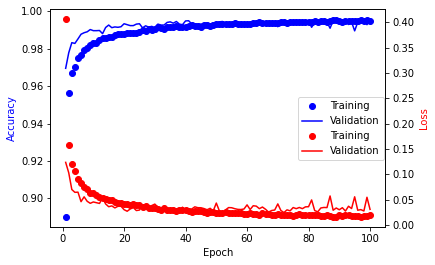

Test accuracy: 0.9952999949455261


In [ ]:
# UNCOMMENT TO RUN THIS MODEL

# model_name="data_augmentation_conv_stack"
# inputs = keras.Input(shape=(28,28,1), name="inputs")

# x = data_augmentation(inputs)
# x = resize_and_rescale(x)

# filters = [32, 64, 128]
# for i,f in enumerate(filters):
#     residual = x
#     x = layers.Conv2D(f, 3, padding="same", activation="relu", name="convA"+str(f)) (x)
#     x = layers.BatchNormalization(name="convA_norm"+str(f)) (x)
#     x = layers.Conv2D(f, 3, padding="same", activation="relu", name="convB"+str(f)) (x)
#     x = layers.BatchNormalization(name="convB_norm"+str(f)) (x)
#     x = layers.Conv2D(f, 3, padding="same", strides=2, activation="relu", name="strides"+str(f)) (x)
#     x = layers.BatchNormalization(name="strides_norm"+str(f)) (x)
#     x = layers.Dropout(0.4) (x)
#     residual = layers.Conv2D(f, 1, padding="same", strides=2, name="convR"+str(f)) (residual)
#     x = layers.add([x, residual], name="add"+str(f))

# x = layers.Flatten(name="flatten") (x)
# outputs = layers.Dense(10, activation="softmax", name="outputs") (x)

# new_model(inputs, outputs,summary=True, plot=True, model_name=model_name)

## Remove the second convolutional layer of each stack

- Data augmentation layer
    - Random rotation
    - Random zoom
- ***3 convolutional layers***
  - kernel size = 3
  - number of filters = 32, 64 and 128
- Conv. layer with strides = 2 instead of max pooling layers, after each conv layer
  - strides = 2
- Batch normalization after each conv layer
- Dropout layer after each conv layer
  - dropout = 0.4
- A residual layer circumventing each stack
- A single dense layer

**Test accuracy: 0.9957**

Model name: model
Total number of parameters: 319210
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential_7 (Sequential)      (None, 28, 28, 1)    0           ['inputs[0][0]']                 
                                                                                                  
 sequential_21 (Sequential)     (None, 28, 28, 1)    0           ['sequential_7[5][0]']           
                                                                                                  
 conv32 (Conv2D)                (None, 28, 28, 32)   320         ['sequential_21[7][0]']          
                                         

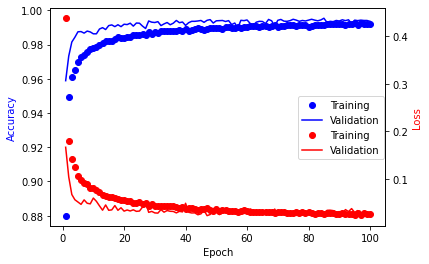

Test accuracy: 0.9957000017166138


In [ ]:
# UNCOMMENT TO RUN THIS MODEL

# model_name="data_augmentation_single_conv"

# inputs = keras.Input(shape=(28,28,1), name="inputs")

# x = data_augmentation(inputs)
# x = resize_and_rescale(x)

# filters = [32, 64, 128]
# for i,f in enumerate(filters):
#     residual = x
#     x = layers.Conv2D(f, 3, padding="same", activation="relu", name="conv"+str(f)) (x)
#     x = layers.BatchNormalization(name="conv_norm"+str(f)) (x)
#     x = layers.Conv2D(f, 3, padding="same", strides=2, activation="relu", name="strides"+str(f)) (x)
#     x = layers.BatchNormalization(name="strides_norm"+str(f)) (x)
#     x = layers.Dropout(0.4) (x)
#     residual = layers.Conv2D(f, 1, padding="same", strides=2, name="convR"+str(f)) (residual)
#     x = layers.add([x, residual], name="add"+str(f))

# x = layers.Flatten(name="flatten") (x)
# outputs = layers.Dense(10, activation="softmax", name="outputs") (x)

# new_model(inputs, outputs,summary=True, plot=True, model_name=model_name)

## Add a hidden dense layer

- Data augmentation layer
    - Random rotation
    - Random zoom
- 3 convolutional layers
  - kernel size = 3
  - number of filters = 32, 64 and 128
- Conv. layer with strides = 2 instead of max pooling layers, after each conv layer
  - strides = 2
- Batch normalization after each conv layer
- Dropout layer after each conv layer
  - dropout = 0.4
- A residual layer circumventing each stack
- ***Two dense layers***
  - ***hidden - 128 neurons***
  - output - 10 neurons

**Test accuracy: 0.9902**

Model name: model
Total number of parameters: 562282
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential_7 (Sequential)      (None, 28, 28, 1)    0           ['inputs[0][0]']                 
                                                                                                  
 sequential_21 (Sequential)     (None, 28, 28, 1)    0           ['sequential_7[6][0]']           
                                                                                                  
 conv32 (Conv2D)                (None, 28, 28, 32)   320         ['sequential_21[8][0]']          
                                         

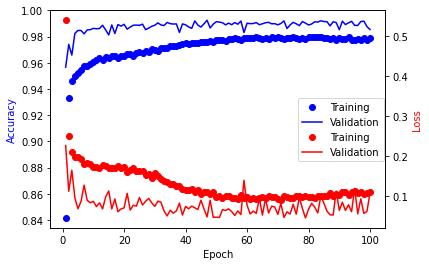

Test accuracy: 0.9905999898910522


In [ ]:
# UNCOMMENT TO RUN THIS MODEL

# model_name="data_augmentation_two_dense"

# inputs = keras.Input(shape=(28,28,1), name="inputs")

# x = data_augmentation(inputs)
# x = resize_and_rescale(x)

# filters = [32, 64, 128]
# for i,f in enumerate(filters):
#     residual = x
#     x = layers.Conv2D(f, 3, padding="same", activation="relu", name="conv"+str(f)) (x)
#     x = layers.BatchNormalization(name="conv_norm"+str(f)) (x)
#     x = layers.Conv2D(f, 3, padding="same", strides=2, activation="relu", name="strides"+str(f)) (x)
#     x = layers.BatchNormalization(name="strides_norm"+str(f)) (x)
#     x = layers.Dropout(0.4) (x)
#     residual = layers.Conv2D(f, 1, padding="same", strides=2, name="convR"+str(f)) (residual)
#     x = layers.add([x, residual], name="add"+str(f))

# x = layers.Flatten(name="flatten") (x)
# x = layers.Dense(128, activation="relu", name="dense") (x)
# x = layers.Dropout(0.4) (x)
# outputs = layers.Dense(10, activation="softmax", name="outputs") (x)

# new_model(inputs, outputs,summary=True, plot=True, model_name=model_name)

# Discussion

## Seems to help:
- Replacing max pooling with a convolutional layer with strides = 2
- Adding droput
- Adding bacth normalization
- Adding data augmentation

## Doesn't seem to help:
- Adding a hidden dense layer
- Adding a residual layer
- Adding a second convolutional layer to each stack

## Architecture that seems to work well:

An architecture that should work fairly well seems to be:

- Data augmentation layer
- 3 convolutional layers
- A conv. layer with strides = 2 instead of max pooling layers, after each conv layer
- Batch normalization after each conv layer
- Dropout layer after each conv layer
- A single dense layer (output)

## Work to do: find better hyperparameters

But we haven't tested different hyperparameters for each layer. We got stuck with the ones we tried from intuition only. To find better hyperparameters we could try:
- Remove the data augmentation, batch normalization and dropout layers.
- Test different combinations of:
    - Convolutional layer: number of filters, kernel size
    - Different sizes of hidden layers
    - Maybe try reinserting a second convolutional layer on each stack?
    - Maybe try ADAM optimization instead of RMSPROP?

Then we could train a new model with the proposed architecture and the "optimal" hyperparameters.